In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM relaxation
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle



In [2]:
region = 'SAtoES'
start_year = 1985.

Opening ./Models/SAtoES_inversion.nc for reading 
solidearthsettings.solidearthsettings
lovenumbers.lovenumbers
rotational.rotational
results.solutionstep
empty init


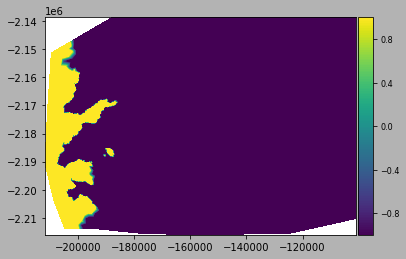

In [3]:
md = loadmodel('./Models/SAtoES_inversion.nc')
plotmodel(md, 'data', md.mask.ice_levelset)

In [4]:
## Relaxation
#Put results of inversion back into the model for forward runs
md.friction.coefficient=md.results.StressbalanceSolution.FrictionCoefficient
relaxation_years = 1 #try 5 years if 1 runs quickly

# Special post-processing of inverted friction coefficient
filename = 'Exp/' +region+ '_coeffront_after_inversion.exp'
if os.path.isfile(filename):
  pos = find(ContourToNodes(md.mesh.x, md.mesh.y, filename, 1))
  md.friction.coefficient[pos] = 10

md.initialization.pressure = np.zeros([md.mesh.numberofvertices,1])
md.initialization.temperature = 250*np.ones([md.mesh.numberofvertices,1])

# Set parameters
md.inversion.iscontrol=0;
md.timestepping.start_time = start_year;
md.timestepping.time_step  = .02;
md.timestepping.final_time = start_year + relaxation_years;
md.settings.output_frequency = (1/md.timestepping.time_step)/5; # 5/yr

In [5]:
with open('ens_dict.pickle', 'rb') as f:
    ens_data = pickle.load(f)

In [6]:
ens_data

{'Trial0': {'sd_after': -0.009540347859468007,
  'tf_after': 2.1149678073476905,
  'calve_after': 533551.2872368456},
 'Trial1': {'sd_after': 0.44091443662936525,
  'tf_after': -2.742911938387232,
  'calve_after': 560331.7565785572},
 'Trial2': {'sd_after': 0.015069066697487277,
  'tf_after': 2.9098566583578425,
  'calve_after': 590241.8611659856},
 'Trial3': {'sd_after': -0.15709691293113348,
  'tf_after': -0.2915334984010517,
  'calve_after': 504529.91550395876},
 'Trial4': {'sd_after': 0.3105076472275024,
  'tf_after': -2.4552980244058316,
  'calve_after': 412903.455808189},
 'Trial5': {'sd_after': 0.33717374823719615,
  'tf_after': 1.7805699672300417,
  'calve_after': 443487.32858009986},
 'Trial6': {'sd_after': 0.1739020969302114,
  'tf_after': -1.05455011919775,
  'calve_after': 553818.7547620493},
 'Trial7': {'sd_after': -0.23279156000581339,
  'tf_after': 0.7451336245311087,
  'calve_after': 427734.7069260108},
 'Trial8': {'sd_after': -0.49528569542479045,
  'tf_after': 0.02560

In [12]:
for ensemble_ID in ens_data.keys():
    #ensemble_ID = 'Trial1' # change ID for each Trial value
    subglacial_discharge = ens_data[ensemble_ID]['sd_after']
    thermal_forcing = ens_data[ensemble_ID]['tf_after']
    calving = ens_data[ensemble_ID]['calve_after']

    print(ensemble_ID)
    print(subglacial_discharge)
    print(thermal_forcing)
    print(calving)
    continue

    # We set the transient parameters
    md.transient.ismovingfront=1
    md.transient.isthermal=0
    md.transient.isstressbalance=1
    md.transient.ismasstransport=1
    md.transient.isgroundingline=1
    md.groundingline.migration = 'SubelementMigration'

    # We set the ocean conditions
    from frontalforcingsrignot import frontalforcingsrignot
    md.frontalforcings = frontalforcingsrignot()

    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    md.frontalforcings.subglacial_discharge = 2.6 * np.ones(md.mesh.numberofvertices) + subglacial_discharge #add LHS value
    md.frontalforcings.thermalforcing = 15.7 * np.ones(md.mesh.numberofvertices) + thermal_forcing #add LHS value
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    md.frontalforcings.basin = 1 * np.ones(md.mesh.numberofvertices)
    md.frontalforcings.numberofbasins = 1

    # We set the calving model (no moving front ... spclevelset is actually ignored)
    from calvingvonmises import calvingvonmises
    md.calving = calvingvonmises()

    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    md.calving.stress_threshold_groundedice = calving #replace with LHS value
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    md.levelset.spclevelset = np.nan * np.ones([md.mesh.numberofvertices,1])
    #md.calving.calvingrate = np.zeros([md.mesh.numberofvertices,1])
    #md.frontalforcings.meltingrate = np.zeros([md.mesh.numberofvertices,1])
    #md.calving.meltingrate = np.ones([md.mesh.numberofvertices,1])

    # Set bed = base for grounded ice
    #md.geometry.base = md.geometry.bed
    #md.geometry.thickness = md.geometry.surface - md.geometry.base

    # Set the requested outputs
    md.stressbalance.requested_outputs=['default']
    md.transient.requested_outputs=['default','IceVolumeAboveFloatation']

Trial0
-0.009540347859468007
2.1149678073476905
533551.2872368456
Trial1
0.44091443662936525
-2.742911938387232
560331.7565785572
Trial2
0.015069066697487277
2.9098566583578425
590241.8611659856
Trial3
-0.15709691293113348
-0.2915334984010517
504529.91550395876
Trial4
0.3105076472275024
-2.4552980244058316
412903.455808189
Trial5
0.33717374823719615
1.7805699672300417
443487.32858009986
Trial6
0.1739020969302114
-1.05455011919775
553818.7547620493
Trial7
-0.23279156000581339
0.7451336245311087
427734.7069260108
Trial8
-0.49528569542479045
0.025606788896391966
498734.5997747347
Trial9
-0.34026549974436665
-1.512919231677784
462750.4188829199


In [17]:
# Go solve
md.verbose.solution=1
md.cluster = generic()
md.settings.waitonlock = np.inf
md = solve(md,'transient')

checking model consistency
marshalling file SAtoES.bin
uploading input file and queueing script
launching solution sequence on remote cluster
cd /efs/issm/issm/trunk-jpl-denis/execution && rm -rf ./SAtoES-07-25-2022-18-01-30-313 && mkdir SAtoES-07-25-2022-18-01-30-313 && cd SAtoES-07-25-2022-18-01-30-313 && mv ../SAtoES-07-25-2022-18-01-30-313.tar.gz ./&& tar -zxf SAtoES-07-25-2022-18-01-30-313.tar.gz  && chmod 755 SAtoES.queue && ./SAtoES.queue

Ice Sheet System Model (ISSM) version  4.19
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
iteration 1/50  time [yr]: 1985 (time step: 0.02)
   computing smb 
   computing new velocity
   computing calving and undercutting
   computing new ice front position
   computing slope of levelset function...
   extrapolation of Vx:
   extrapolation of Vy:
   extrapolation of Thickness:
   call computational core:
   looking for icebergs to kill
   computing basal mass balance
   computing mass transport
   cal

In [18]:
from export_netCDF import export_netCDF

md.inversion.cost_functions = md.inversion.cost_functions.astype(np.float64)
for i in range(len(md.results.TransientSolution)):
    md.results.TransientSolution[i].step = np.float64(md.results.TransientSolution[i].step)
    
export_netCDF(md, "./Models/SAtoES_relaxation_"+ensemble_ID+).nc")

field md.solidearth.external is None
qmu is skipped until it is more stable


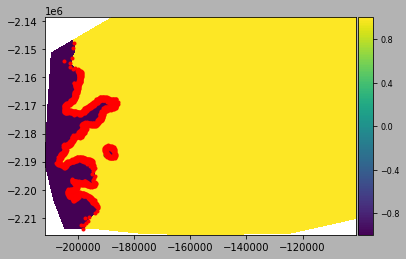

In [12]:
time = [md.results.TransientSolution[i].time for i in range(len(md.results.TransientSolution))]
VAF = [md.results.TransientSolution[i].IceVolumeAboveFloatation for i in range(len(md.results.TransientSolution))]

# Look for terminus advance
idx = np.logical_and(np.array(md.mask.ice_levelset) > 0, \
                     np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() <= 0)
pos_advance = np.where(idx)[0]

# Look for terminus retreat
idx = np.logical_and(np.array(md.mask.ice_levelset) < 0, \
                     np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel() >= 0)
pos_retreat = np.where(idx)[0]

#fig = plt.figure(figsize=(10,10))
#plotmodel(md, 'data', np.array(md.mask.ice_levelset), \
#              'data', np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
#              'caxis#all', [-1., +1.])
plotmodel(md, 'data', np.array(md.mask.ice_levelset) - np.array(md.results.TransientSolution[5].MaskIceLevelset).ravel(), \
              'caxis#all', [-1, +1])

plt.plot(md.mesh.x[pos_advance], md.mesh.y[pos_advance], 'g.')
plt.plot(md.mesh.x[pos_retreat], md.mesh.y[pos_retreat], 'r.')

In [10]:
md.results.TransientSolution[5].MaskIceLevelset

array([[-16710.24741481],
       [  5284.22963663],
       [  4062.45684144],
       ...,
       [  -812.40708016],
       [ -1777.59417679],
       [-89056.42866602]])

In [25]:
md.calving

   Calving VonMises parameters:
         stress_threshold_gro...: 500000.0        -- sigma_max applied to grounded ice only [Pa]
         stress_threshold_flo...: 150000.0        -- sigma_max applied to floating ice only [Pa]
         min_thickness          : 0.0             -- minimum thickness below which no ice is allowed [m]